In [1]:
import numpy as np
import pandas as pd  

/opt/anaconda3/lib/python3.8/site-packages/pandas/core/computation/expressions.py:20: UserWarning: Pandas requires version '2.7.3' or newer of 'numexpr' (version '2.7.1' currently installed).
  from pandas.core.computation.check import NUMEXPR_INSTALLED


In [2]:
full_df = pd.read_csv("/Users/kris/Library/CloudStorage/OneDrive-Personal/Data science/big data project/full_df.csv")


In [99]:
full_df = full_df[~((full_df['Year'] == 2024) & (full_df['Week'] > 8))]
df = pd.DataFrame(full_df)
# Group by 'County' and create a dictionary of DataFrames
county_dfs = {county: group.reset_index(drop=True) for county, group in df.groupby('County')}



/opt/anaconda3/lib/python3.8/site-packages/ipykernel/ipkernel.py:287: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


# data for hyperparameter testing

In [106]:
from statsmodels.tsa.stattools import adfuller
from sklearn.preprocessing import StandardScaler, OneHotEncoder
import pandas as pd

# Iterate over each county DataFrame
for county, county_df in county_dfs.items():
    print(f"Processing data for: {county}")
    

    # Normalize the data
    scaler = StandardScaler()
    scaled_features = scaler.fit_transform(county_df[['Sea temperature', 'Week_Lice_Counts', 'Duration']])
    county_df[['Sea temperature', 'Week_Lice_Counts', 'Duration']] = scaled_features
    
    # Create 'Date' column from 'Year' and 'Week'
    county_df['Date'] = pd.to_datetime(county_df['Year'].astype(str) + county_df['Week'].astype(str) + '1', format='%Y%W%w')
    
    # Set the 'Date' column as index
    county_df.set_index('Date', inplace=True)


    # Update the county_dfs with the processed DataFrame
    county_dfs[county] = county_df

Processing data for: Møre og Romsdal
Processing data for: Nordland
Processing data for: Rogaland
Processing data for: Troms og Finnmark
Processing data for: Trøndelag
Processing data for: Vestland


In [ ]:
import os

# Create a directory to save 
os.makedirs('county_csvs', exist_ok=True)

# Iterate over the dictionary and save 
for county, df in county_dfs.items():
    # Define the file name,
    filename = f"county_csvs/{county.replace(' ', '_')}.csv"
    
    # Save the DataFrame to a CSV file
    df.to_csv(filename)
    
    print(f"Saved {county} data to {filename}")

Saved Møre og Romsdal data to county_csvs/Møre_og_Romsdal.csv
Saved Nordland data to county_csvs/Nordland.csv
Saved Rogaland data to county_csvs/Rogaland.csv
Saved Troms og Finnmark data to county_csvs/Troms_og_Finnmark.csv
Saved Trøndelag data to county_csvs/Trøndelag.csv
Saved Vestland data to county_csvs/Vestland.csv


/opt/anaconda3/lib/python3.8/site-packages/ipykernel/ipkernel.py:287: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


### data for modeling

In [89]:
from statsmodels.tsa.stattools import adfuller
from sklearn.preprocessing import StandardScaler, OneHotEncoder
import pandas as pd

# Iterate over each county DataFrame
for county, county_df in county_dfs.items():
    print(f"Processing data for: {county}")
    
    # Sort by 'Year' and 'Week' to ensure proper ordering
    county_df = county_df.sort_values(by=['Year', 'Week'])
    
    # Check for stationarity
    result = adfuller(county_df['Outbreak_Count'])
    print(f'ADF Statistic: {result[0]}')
    print(f'p-value: {result[1]}')
    
    # If the series is not stationary, apply differencing
    if result[1] > 0.05:
        county_df['Outbreak_Count'] = county_df['Outbreak_Count'].diff().dropna()
        county_df = county_df.dropna()
        
    # Normalize the data
    scaler = StandardScaler()
    scaled_features = scaler.fit_transform(county_df[['Sea temperature', 'Week_Lice_Counts', 'Duration']])
    county_df[['Sea temperature', 'Week_Lice_Counts', 'Duration']] = scaled_features
    
    # Create 'Date' column from 'Year' and 'Week'
    county_df['Date'] = pd.to_datetime(county_df['Year'].astype(str) + county_df['Week'].astype(str) + '1', format='%Y%W%w')
    
    # Set the 'Date' column as index
    county_df.set_index('Date', inplace=True)

    # Ensure frequency is set to monthly
    county_df = county_df.asfreq('W-MON')  # 'MS' for month start; you can use 'M' for month end

    # Update the county_dfs with the processed DataFrame
    county_dfs[county] = county_df

Processing data for: Møre og Romsdal
ADF Statistic: -0.13600636947790107
p-value: 0.9457319556158016
Processing data for: Nordland
ADF Statistic: -3.3270087706327187
p-value: 0.013713511103176703
Processing data for: Rogaland
ADF Statistic: -0.7822092240934615
p-value: 0.8242921980962041
Processing data for: Troms og Finnmark
ADF Statistic: -3.441842300497698
p-value: 0.00961253248614305
Processing data for: Trøndelag
ADF Statistic: -1.6215611105920855
p-value: 0.47191096234143015
Processing data for: Vestland
ADF Statistic: -1.7303737447768477
p-value: 0.4155348432224657


In [133]:
county_dfs['Vestland']['Outbreak_Count'].max()

/opt/anaconda3/lib/python3.8/site-packages/ipykernel/ipkernel.py:287: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


5.26984126984127

In [6]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from skforecast.ForecasterSarimax import ForecasterSarimax
from skforecast.model_selection_sarimax import backtesting_sarimax
from skforecast.model_selection_sarimax import grid_search_sarimax
from pmdarima import ARIMA
from sklearn.metrics import mean_absolute_error
import warnings
warnings.filterwarnings('ignore')

### Data Split 

In [110]:
from sktime.forecasting.model_selection import temporal_train_test_split
import pandas as pd

# Split the data into train, validation, and test sets
split_data = {}
for county, county_df in county_dfs.items():
    print(f"Splitting data for: {county}")
    
    # Ensure the Date index is properly aligned and sorted
    county_df.sort_index(inplace=True)
    
    y = county_df['Outbreak_Count']
    exog = county_df.drop(columns=['Outbreak_Count','County','Year','Week'])
    
    # Split the data into train and test sets
    y_train, y_test, X_train, X_test = temporal_train_test_split(y, exog, test_size=0.2)
    
    # Store the splits in a dictionary
    split_data[county] = {
        'y_train': y_train, 'y_test': y_test,
        'X_train': X_train, 'X_test': X_test
    }
    
    # Debug: Print out the start and end dates for each split
    print(f"{county} - y_train start: {y_train.index[0]}, end: {y_train.index[-1]}")
    print(f"{county} - y_test start: {y_test.index[0]}, end: {y_test.index[-1]}")
    print()

Splitting data for: Møre og Romsdal
Møre og Romsdal - y_train start: 2012-01-02 00:00:00, end: 2021-09-13 00:00:00
Møre og Romsdal - y_test start: 2021-09-20 00:00:00, end: 2024-02-19 00:00:00

Splitting data for: Nordland
Nordland - y_train start: 2012-01-02 00:00:00, end: 2021-09-13 00:00:00
Nordland - y_test start: 2021-09-20 00:00:00, end: 2024-02-19 00:00:00

Splitting data for: Rogaland
Rogaland - y_train start: 2012-01-02 00:00:00, end: 2021-09-13 00:00:00
Rogaland - y_test start: 2021-09-20 00:00:00, end: 2024-02-19 00:00:00

Splitting data for: Troms og Finnmark
Troms og Finnmark - y_train start: 2012-01-02 00:00:00, end: 2021-09-13 00:00:00
Troms og Finnmark - y_test start: 2021-09-20 00:00:00, end: 2024-02-19 00:00:00

Splitting data for: Trøndelag
Trøndelag - y_train start: 2012-01-02 00:00:00, end: 2021-09-13 00:00:00
Trøndelag - y_test start: 2021-09-20 00:00:00, end: 2024-02-19 00:00:00

Splitting data for: Vestland
Vestland - y_train start: 2012-01-02 00:00:00, end: 202

## time split method

In [7]:
import pandas as pd

# Define the end date for the training set
end_train = '2021-01-01 23:59:59'

# Split the data into train and test sets manually
split_data = {}
for county, county_df in county_dfs.items():
    print(f"Splitting data for: {county}")
    
    # Ensure the Date index is properly aligned and sorted
    county_df.sort_index(inplace=True)
    
    y = county_df['Outbreak_Count']
    exog = county_df.drop(columns=['Outbreak_Count','County','Year','Week'])
    
    # Perform the manual split based on the specified end date for training data
    y_train = y.loc[:end_train]
    y_test = y.loc[end_train:]
    X_train = exog.loc[:end_train]
    X_test = exog.loc[end_train:]
    
    # Store the splits in a dictionary
    split_data[county] = {
        'y_train': y_train, 
        'y_test': y_test,
        'X_train': X_train, 
        'X_test': X_test
    }
    
    # Debug: Print out the start and end dates for each split
    print(
        f"{county} - Train dates : {y_train.index.min()} --- {y_train.index.max()}  "
        f"(n={len(y_train)})"
    )
    print(
        f"{county} - Test dates  : {y_test.index.min()} --- {y_test.index.max()}  "
        f"(n={len(y_test)})"
    )
    print()

Splitting data for: Møre og Romsdal
Møre og Romsdal - Train dates : 2012-01-09 00:00:00 --- 2020-12-28 00:00:00  (n=469)
Møre og Romsdal - Test dates  : 2021-01-04 00:00:00 --- 2024-02-19 00:00:00  (n=164)

Splitting data for: Nordland
Nordland - Train dates : 2012-01-02 00:00:00 --- 2020-12-28 00:00:00  (n=470)
Nordland - Test dates  : 2021-01-04 00:00:00 --- 2024-02-19 00:00:00  (n=164)

Splitting data for: Rogaland
Rogaland - Train dates : 2012-01-09 00:00:00 --- 2020-12-28 00:00:00  (n=469)
Rogaland - Test dates  : 2021-01-04 00:00:00 --- 2024-02-19 00:00:00  (n=164)

Splitting data for: Troms og Finnmark
Troms og Finnmark - Train dates : 2012-01-02 00:00:00 --- 2020-12-28 00:00:00  (n=470)
Troms og Finnmark - Test dates  : 2021-01-04 00:00:00 --- 2024-02-19 00:00:00  (n=164)

Splitting data for: Trøndelag
Trøndelag - Train dates : 2012-01-09 00:00:00 --- 2020-12-28 00:00:00  (n=469)
Trøndelag - Test dates  : 2021-01-04 00:00:00 --- 2024-02-19 00:00:00  (n=164)

Splitting data for:

/opt/anaconda3/lib/python3.8/site-packages/ipykernel/ipkernel.py:287: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


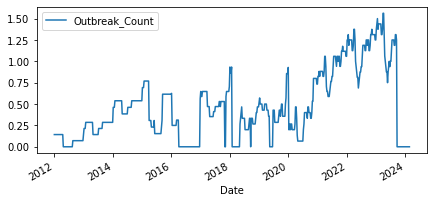

In [82]:
fig, ax=plt.subplots(figsize=(7, 3))
county_dfs['Troms og Finnmark']['Outbreak_Count'].plot(ax=ax)
ax.legend();

In [111]:
split_data["Vestland"]['X_train']

/opt/anaconda3/lib/python3.8/site-packages/ipykernel/ipkernel.py:287: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


,Sea temperature,Week_Lice_Counts,Duration
Date,,,
2012-01-02,-0.809674,-0.181754,-2.479848
2012-01-09,-0.842134,0.964877,-2.479848
2012-01-16,-0.858971,-0.904658,-2.479848
2012-01-23,-1.033377,1.023522,-2.479848
2012-01-30,-1.215727,-1.169877,-2.479848
...,...,...,...
2021-08-16,1.572004,-0.395709,-0.221666
2021-08-23,1.375219,0.129755,-0.221666
2021-08-30,1.074190,-0.124100,-0.160311


### hyper p tuning

In [ ]:
## previosu

from pmdarima import auto_arima


# auto_arima to determine the best parameters
model = auto_arima(
    y_train,
    start_p=0, start_q=0,
    max_p=3, max_q=3,
    seasonal=True,        # true if seasonality
    start_P=0, start_Q=0,
    max_P=3, max_Q=3,
    m=52,                 #  seasonality
    d=None,               # auto_arima determine the optimal d
    D=None,               # auto_arima determine the optimal D
    trace=True,          
    error_action='ignore',
    suppress_warnings=True,
    stepwise=True    
)

#  summary of the model
print(model.summary())

# save the optimal parameters 
optimal_params = {
    'order': model.order,
    'seasonal_order': model.seasonal_order,
    'aic': model.aic()
}

# forecast using the selected model
forecast = model.predict(n_periods=len(y_test), exogenous=X_test)

In [ ]:
from pmdarima import auto_arima

forecasters = {}
optimal_params = {}

# Loop through each county in the split_data dictionary
for county, data in split_data.items():
    print(f"Training SARIMAX model for: {county}")
    
    # Apply asfreq  missing values are filled
    y_train = data['y_train'].asfreq('W-MON').ffill()
    X_train = data['X_train'].asfreq('W-MON').ffill()
    # Use auto_arima to determine the optimal parameters
    model = auto_arima(
        y                 = y_train,
        exogenous         = X_train, 
        start_p           = 0,
        start_q           = 0,
        max_p             = 3,
        max_q             = 3,
        seasonal          = True,
        start_P           = 0,
        start_Q           = 0,
        max_P             = 3,
        max_Q             = 3,
        m                 = 52,  # seasonal period 
        d                 = None, 
        D                 = None,  
        trace             = True,
        error_action      = 'ignore',
        suppress_warnings = True,
        stepwise          = True
    )
    
    # Save the optimal parameters
    optimal_params[county] = {
        'order': model.order,
        'seasonal_order': model.seasonal_order,
        'aic': model.aic()
    }
    
    print(f"Optimal parameters for {county}:")
    print(f"Order: {model.order}")
    print(f"Seasonal Order: {model.seasonal_order}")
    print(f"AIC: {model.aic()}")
    print()

In [85]:
optimal_params

{'Møre og Romsdal': {'order': (0, 0, 0),
  'seasonal_order': (0, 1, 0, 52),
  'aic': -182.33868945008615},
 'Nordland': {'order': (0, 1, 0),
  'seasonal_order': (1, 0, 0, 52),
  'aic': -1.8238252316543448},
 'Rogaland': {'order': (0, 0, 0),
  'seasonal_order': (0, 0, 0, 52),
  'aic': 222.2236304520619},
 'Troms og Finnmark': {'order': (0, 1, 0),
  'seasonal_order': (0, 0, 0, 52),
  'aic': -160.297680541646},
 'Trøndelag': {'order': (0, 0, 1),
  'seasonal_order': (1, 0, 0, 52),
  'aic': -167.41138390510613},
 'Vestland': {'order': (0, 0, 0),
  'seasonal_order': (1, 0, 0, 52),
  'aic': 77.9836106148412}}

### Defining training testing sets for testing

In [84]:
# Assuming split_data contains your data already split into train, validation, and test sets
y_train = split_data['Vestland']['y_train']
X_train = split_data['Vestland']['X_train']
y_test = split_data['Vestland']['y_test']
X_test = split_data['Vestland']['X_test']

### statsmodels sarimax 

In [ ]:
from statsmodels.tsa.statespace.sarimax import SARIMAX
from sklearn.metrics import mean_squared_error

# Ensure the DateTimeIndex has a frequency and fill any missing values
y_train = y_train.asfreq('W-MON').ffill()
y_test = y_test.asfreq('W-MON').ffill()
X_train = X_train.asfreq('W-MON').ffill()
X_test = X_test.asfreq('W-MON').ffill()


# Fit the SARIMAX model
warnings.filterwarnings("ignore", category=UserWarning, message='Non-invertible|Non-stationary')
model = SARIMAX(endog=y_train, exog=X_train, order=(0, 0, 0), seasonal_order=(1, 0, 0, 52))
model_res = model.fit(disp=0)
warnings.filterwarnings("default")

# Print the model summary
print(model_res.summary())

# Make predictions on the test set
#predictions = model_res.predict(start= y_test.index[0], end= y_test.index[-1], exog=X_test)
# Manually define the start and end timestamps for prediction



                                     SARIMAX Results                                      
Dep. Variable:                     Outbreak_Count   No. Observations:                  404
Model:             SARIMAX(1, 0, 0)x(1, 0, 0, 52)   Log Likelihood                 681.878
Date:                            Sat, 10 Aug 2024   AIC                          -1351.757
Time:                                    11:40:42   BIC                          -1327.748
Sample:                                01-09-2012   HQIC                         -1342.253
                                     - 09-30-2019                                         
Covariance Type:                              opg                                         
                       coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------------
Sea temperature      0.0017      0.005      0.370      0.711      -0.008       0.011
Week_Lice_Counts 

In [ ]:
#start_date = '2021-01-01 00:00:00'  # Example start date
#end_date = '2023-12-31 23:59:59'    # Example end date

# Make predictions on the test set
#predictions = model_res.predict(start=start_date, end=end_date, exog=X_test.loc[start_date:end_date])
#predictions = model_res.predict(start=len(y_train), end=len(y_train) + len(y_test) - 1, exog=X_test)
# Use the exact start and end dates from y_test index
start_date = y_test.index[0]  # Start from the first date in y_test
end_date = y_test.index[-1]   # End at the last date in y_test

# Make predictions on the test set
predictions = model_res.predict(start=start_date, end=end_date, exog=X_test)


# Calculate the MSE
mse = mean_squared_error(y_train, predictions)
print(f"Mean Squared Error (MSE): {mse}")

## skforecast  sariamx

In [13]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from skforecast.Sarimax import Sarimax
from skforecast.ForecasterSarimax import ForecasterSarimax
from skforecast.model_selection_sarimax import backtesting_sarimax
from skforecast.model_selection_sarimax import grid_search_sarimax
from skforecast.datasets import fetch_dataset
from pmdarima import ARIMA
from pmdarima import auto_arima
from statsmodels.tsa.statespace.sarimax import SARIMAX
from sklearn.metrics import mean_absolute_error
import warnings
warnings.filterwarnings('ignore')

In [101]:
# Ensure the DateTimeIndex has a frequency and fill any missing values
y_train = y_train.asfreq('W-MON').ffill()
y_test = y_test.asfreq('W-MON').ffill()
X_train = X_train.asfreq('W-MON').ffill()
X_test = X_test.asfreq('W-MON').ffill()


forecaster = ForecasterSarimax(
                 regressor=Sarimax(order=(0, 1, 0), seasonal_order=(3, 0, 0, 52), maxiter=1000),
             )

forecaster.fit(y= y_train, suppress_warnings=True)
forecaster

ForecasterSarimax 
Regressor: Sarimax(0,1,0)(3,0,0)[52] 
Regressor parameters: {'concentrate_scale': False, 'dates': None, 'disp': False, 'enforce_invertibility': True, 'enforce_stationarity': True, 'freq': None, 'hamilton_representation': False, 'maxiter': 1000, 'measurement_error': False, 'method': 'lbfgs', 'missing': 'none', 'mle_regression': True, 'order': (0, 1, 0), 'seasonal_order': (3, 0, 0, 52), 'simple_differencing': False, 'sm_fit_kwargs': {}, 'sm_init_kwargs': {}, 'sm_predict_kwargs': {}, 'start_params': None, 'time_varying_regression': False, 'trend': None, 'trend_offset': 1, 'use_exact_diffuse': False, 'validate_specification': True} 
fit_kwargs: {} 
Window size: 1 
Transformer for y: None 
Transformer for exog: None 
Exogenous included: False 
Type of exogenous variable: None 
Exogenous variables names: None 
Training range: [Timestamp('2012-01-09 00:00:00'), Timestamp('2021-09-13 00:00:00')] 
Training index type: DatetimeIndex 
Training index frequency: W-MON 
Creation d

In [92]:
predictions = forecaster.predict(steps=127)
predictions.head(3)

2021-09-20   -0.062192
2021-09-27   -0.066930
2021-10-04   -0.054701
Freq: W-MON, Name: pred, dtype: float64

In [117]:
error_mse = mean_absolute_error(
                y_true = y_test,
                y_pred = predictions
            )

print(f"Test error (mse): {error_mse}")

Test error (mse): 1.709951678425365


In [ ]:
# Plot predictions
import matplotlib.pyplot as plt

# Plotting the data
fig, ax = plt.subplots(figsize=(20, 10))

# Plot the training data, test data, and predictions
y_train.plot(ax=ax, label='train')
y_test.plot(ax=ax, label='test')
predictions.plot(ax=ax, label='predictions')

# Set the y-axis limits to between -0.5 and 5
#ax.set_ylim([-0.5,0.5])

# Add a legend
ax.legend()

# Display the plot
plt.show()

/opt/anaconda3/lib/python3.8/site-packages/ipykernel/ipkernel.py:287: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


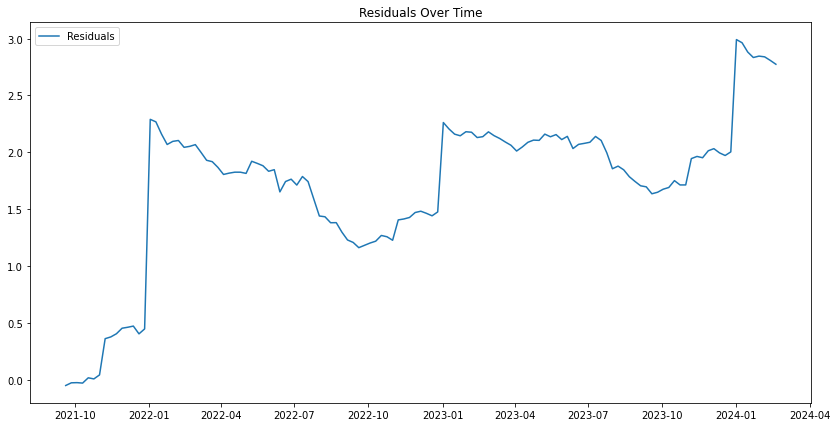

<Figure size 720x432 with 0 Axes>

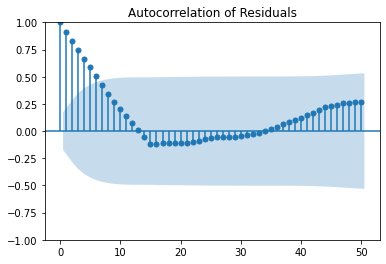

In [122]:
# Plot residuals
residuals = y_test - predictions
plt.figure(figsize=(14, 7))
plt.plot(y_test.index, residuals, label='Residuals')
plt.title('Residuals Over Time')
plt.legend()
plt.show()

from statsmodels.graphics.tsaplots import plot_acf

plt.figure(figsize=(10, 6))
plot_acf(residuals, lags=50)
plt.title('Autocorrelation of Residuals')
plt.show()

In [ ]:
forecast = model_res.get_forecast(steps=len(y_test), exog=X_test)
mean_forecast = forecast.predicted_mean
conf_int = forecast.conf_int()

plt.figure(figsize=(14, 7))
plt.plot(y_test.index, y_test, label='Actual')
plt.plot(y_test.index, mean_forecast, color='red', label='Forecast')
plt.fill_between(y_test.index, conf_int.iloc[:, 0], conf_int.iloc[:, 1], color='pink', alpha=0.3)
plt.title('Forecast with Confidence Intervals')
plt.legend()
plt.show()


In [ ]:


# For Testing Data
test_predictions = model_res.predict(start=y_test.index[0], end=y_test.index[-1], exog=X_test)
test_mse = mean_squared_error(y_test, test_predictions)
test_rmse = np.sqrt(test_mse)
test_mae = mean_absolute_error(y_test, test_predictions)

print(f"Training Data - MSE: {train_mse}, RMSE: {train_rmse}, MAE: {train_mae}")
print(f"Testing Data - MSE: {test_mse}, RMSE: {test_rmse}, MAE: {test_mae}")

In [112]:
# Assuming split_data contains your data already split into train, validation, and test sets
y_train = split_data['Vestland']['y_train']
X_train = split_data['Vestland']['X_train']
y_test = split_data['Vestland']['y_test']
X_test = split_data['Vestland']['X_test']

In [113]:
# Ensure the DateTimeIndex has a frequency and fill any missing values
y_train = y_train.asfreq('W-MON').ffill()
y_test = y_test.asfreq('W-MON').ffill()
X_train = X_train.asfreq('W-MON').ffill()
X_test = X_test.asfreq('W-MON').ffill()

forecaster = ForecasterSarimax(
                 regressor=Sarimax(order=(0, 1, 0), seasonal_order=(3, 0, 0, 52), maxiter=200),
             )

forecaster.fit(
    y                 = y_train, 
    exog              = X_train,
    suppress_warnings = True
)

/opt/anaconda3/lib/python3.8/site-packages/ipykernel/ipkernel.py:287: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


In [116]:
predictions = forecaster.predict(
                  steps = 127,
                  exog  = X_test
              )
predictions.head(3)

2021-09-20    2.016043
2021-09-27    1.992376
2021-10-04    1.990894
Freq: W-MON, Name: pred, dtype: float64

# TCN

In [146]:
from tcn import TCN, tcn_full_summary

/opt/anaconda3/lib/python3.8/site-packages/ipykernel/ipkernel.py:287: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


In [ ]:
from math import sqrt
import numpy as np
import pandas as pd
from matplotlib import pyplot as plt
import seaborn as sns
from sklearn.preprocessing import StandardScaler, MinMaxScaler
from sklearn.metrics import mean_squared_error, r2_score
from tensorflow.keras.preprocessing.sequence import TimeseriesGenerator
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, LSTM, Input
from tensorflow.keras.callbacks import EarlyStopping


In [ ]:
def preprocess_data(df:pd.DataFrame, columns:list, perc_train:float, timesteps:int, steps_to_predict:int, split:bool):
  #Remove year 2017 (2017 will be used to test and benchmark the different models)

  df_internal = county_dfs['Vestland'][columns]

  X_scaler = MinMaxScaler()
  df_X = X_scaler.fit_transform(df_internal)

  df_y = df_internal.to_numpy()

  #Generate Sample Sequences
  timesteps = timesteps 
  steps_to_predict = steps_to_predict #
  generator = TimeseriesGenerator(df_X, df_y, length=timesteps, batch_size=steps_to_predict)

  
  X = np.array([x[0].reshape(timesteps,x[0].shape[-1]) for x in generator])
  y = np.array([x[1][0][0].reshape(1) for x in generator])
lps the
  #Normalize data into a 0 / 1 range.
  y_scaler = MinMaxScaler()
  y = y_scaler.fit_transform(y)

  if split:
    #Split data
    size_train = int(len(X) * perc_train)
    X_train = X[:size_train]
    y_train = y[:size_train]
    X_test = X[size_train:]
    y_test = y[size_train:]

    plt.figure(figsize=(20,6))
    sns.lineplot(x=df_internal[timesteps:len(y_train)+timesteps].index, y=y_train[:,0], label='Train')
    sns.lineplot(x=df_internal[len(y_train)+timesteps:].index, y=y_test[:,0], label='Test')
    plt.show()

    #Return data (inluding scaler for inverse scaling)
    return X_train, X_test, y_train, y_test, X_scaler, y_scaler

  else:
    # Return all data for training
    X_train = X
    y_train = y
    return X_train, y_train, X_scaler, y_scaler

/opt/anaconda3/lib/python3.8/site-packages/ipykernel/ipkernel.py:287: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


In [172]:
def metrics(results, y_test, y_pred):
  losses = pd.DataFrame(results.history)
  losses.plot(figsize=(15,6), title='Loss', xlabel = "Epochs", ylabel='Loss')
  plt.figure(figsize=(15,6))
  plt.xlabel('Date')
  plt.ylabel('Outbreak Count, Vestland')
# Plot the test data
  #sns.lineplot(x=df.index[-len(y_test):], y=y_test[:,0], label='Test')
 # sns.lineplot(x=df.index[-len(y_pred):], y=y_pred[:,0], label='Predict')
  
    # Plot the test data
  sns.lineplot(x=df.index[-len(y_test):], y=y_test[:,0], label='Test')
  sns.lineplot(x=df.index[-len(y_pred):], y=y_pred[:,0], label='Predict')

  plt.show()
  r2 = r2_score(y_test, y_pred)
  rmse = sqrt(mean_squared_error(y_test, y_pred))
  print('Model Metrics:')
  print(f'R2_Score: {r2}')
  print(f'RMSE: {rmse}' )
  return r2, rmse

In [150]:
def TCN_model(X_shape:tuple, patience=None):
  model = Sequential()
  #Pass input shape
  model.add(Input(shape=(X_shape[1],X_shape[2])))
  model.add(TCN(nb_filters=64,
                kernel_size=3,
                nb_stacks=1,
                dilations=[1, 2, 4, 8],
                use_layer_norm=True,
                dropout_rate=0.02,
                kernel_initializer='glorot_uniform'))
  model.add(Dense(1))
  model.compile(optimizer='adam', loss='mse')
  if patience:
    early_stop = EarlyStopping(monitor='val_loss', patience=patience)
    return model, early_stop
  else:
    return model

/opt/anaconda3/lib/python3.8/site-packages/ipykernel/ipkernel.py:287: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


In [168]:
timesteps = 52
steps_to_predict = 1

/opt/anaconda3/lib/python3.8/site-packages/ipykernel/ipkernel.py:287: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


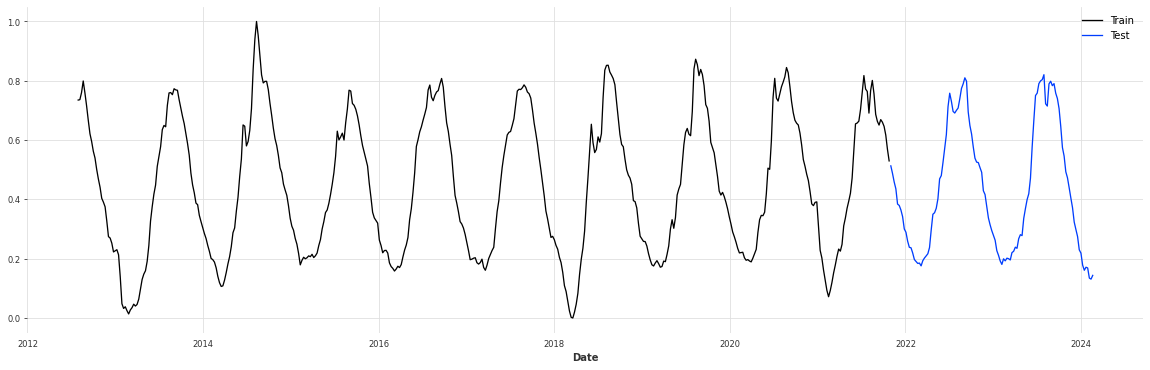

In [159]:
columns = ['Sea temperature', 'Week_Lice_Counts', 'Duration']
X_train, X_test, y_train, y_test, X_scaler, y_scaler = preprocess_data(df, columns, 0.8, timesteps, steps_to_predict, split=True)

In [169]:
model = TCN_model(X_train.shape)
model.summary()

Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 tcn_1 (TCN)                 (None, 64)                88384     
                                                                 
 dense_1 (Dense)             (None, 1)                 65        
                                                                 
Total params: 88,449
Trainable params: 88,449
Non-trainable params: 0
_________________________________________________________________


In [170]:
results = model.fit(X_train, y_train, validation_data=(X_test,y_test), epochs=40)
y_pred = model.predict(X_test)

Epoch 1/40
16/16 [==============================] - 6s 91ms/step - loss: 1.1223 - val_loss: 0.0745
Epoch 2/40
16/16 [==============================] - 1s 44ms/step - loss: 0.1464 - val_loss: 0.0120
Epoch 3/40
16/16 [==============================] - 1s 44ms/step - loss: 0.0881 - val_loss: 0.0601
Epoch 4/40
16/16 [==============================] - 1s 45ms/step - loss: 0.0615 - val_loss: 0.0305
Epoch 5/40
16/16 [==============================] - 1s 45ms/step - loss: 0.0458 - val_loss: 0.0562
Epoch 6/40
16/16 [==============================] - 1s 43ms/step - loss: 0.0550 - val_loss: 0.0086
Epoch 7/40
16/16 [==============================] - 1s 43ms/step - loss: 0.0495 - val_loss: 0.0067
Epoch 8/40
16/16 [==============================] - 1s 48ms/step - loss: 0.0472 - val_loss: 0.0067
Epoch 9/40
16/16 [==============================] - 1s 47ms/step - loss: 0.0396 - val_loss: 0.0281
Epoch 10/40
16/16 [==============================] - 1s 44ms/step - loss: 0.0361 - val_loss: 0.0066
Epoch 11/

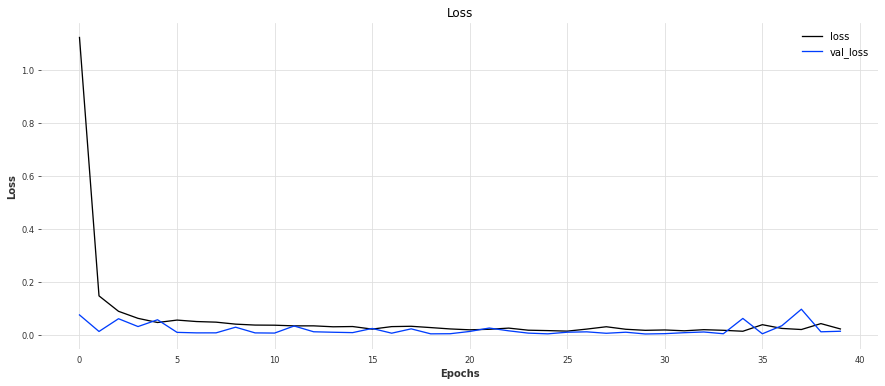

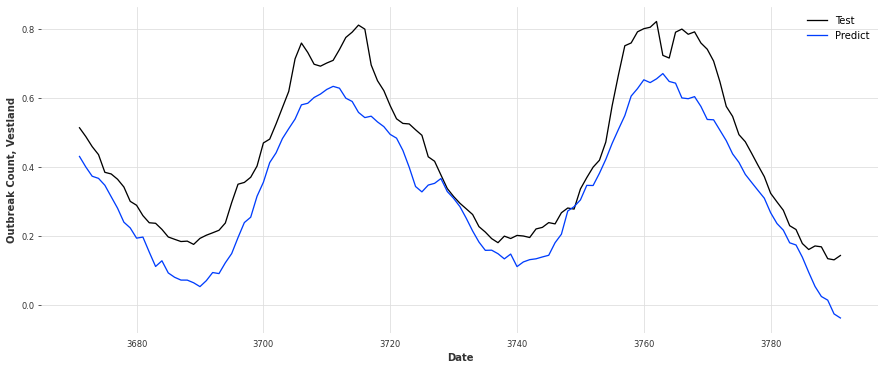

Model Metrics:
R2_Score: 0.7256136550711141
RMSE: 0.11313002179576986


In [173]:
r2_one, rmse_one = metrics(results, y_test, y_pred)